<a href="https://colab.research.google.com/github/eloigil/fast.ai_playground/blob/main/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1020]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1021]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [1022]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('.')

In [1023]:
Path.BASE_PATH = path

In [1024]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [1025]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [1026]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
# print(threes)
# print(sevens)

In [1027]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [1028]:
type(im3) #PIL is Pynthon Imaging Library

PIL.PngImagePlugin.PngImageFile

In [1029]:
# Converting it to NumPy array
array(im3)[4:10,4:10] # the 4:10 is just selecting a part of the total array

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [1030]:
# Converting it to PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [1031]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22]) #pandas dataframe (cause it has background_gradient)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [1032]:
seven_tensors = [tensor(Image.open(o)) for o in sevens] #convert all sevens to tensors
three_tensors = [tensor(Image.open(o)) for o in threes] #convert all threes to tensors
len(three_tensors),len(seven_tensors)

(6131, 6265)

torch.Size([28, 28])

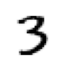

In [1033]:
show_image(three_tensors[1]) #fast.ai command to display a tensor
three_tensors[1].shape

In [1034]:
# funny note
print(type(three_tensors[1])) # python type says its a pytorch library tensor
print(three_tensors[1].type()) # type method shows the type of tensor

<class 'torch.Tensor'>
torch.ByteTensor


In [1035]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [1036]:
rank = len(stacked_threes.shape)
rank

3

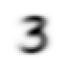

In [1037]:
mean3 = stacked_threes.mean(0) # take the mean from the first axis
show_image(mean3);

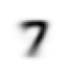

In [1038]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

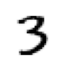

In [1039]:
a_3 = stacked_threes[1]
show_image(a_3)

In [1040]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 norm
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [1041]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

## Computing Metrics Using Broadcasting

In [1042]:
# doing the same before for the validation sets
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [1043]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3) #process run once

tensor(0.1114)

In [1044]:
# but we have to do the process for the entire valiation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
print('valid_3_tens shape:', valid_3_tens.shape)
print('mean3 shape:', mean3.shape)
valid_3_dist, valid_3_dist.shape
# it returned an array of 1010 values due to Broadcasting: when it finds different shapes it acts as if mean3 was copied 1010 times

valid_3_tens shape: torch.Size([1010, 28, 28])
mean3 shape: torch.Size([28, 28])


(tensor([0.1163, 0.1378, 0.1467,  ..., 0.1474, 0.1259, 0.1078]),
 torch.Size([1010]))

In [1045]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [1046]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [1047]:
# we can broadcast the process into the entire set
is_3(valid_3_tens)

tensor([ True,  True, False,  ...,  True,  True,  True])

In [1048]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent SGD

In [1049]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

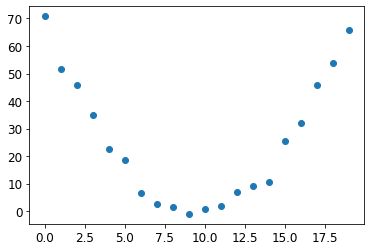

In [1050]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [1051]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [1052]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt() # mean squared error

### 7 steps process

1. Initialize the parameters

In [1053]:
params = torch.randn(3).requires_grad_() # initialize the parameters to random values, and tell PyTorch that we want to track their gradients

In [1054]:
#hide
orig_params = params.clone()

2. Calculate the predictions

In [1055]:
preds = f(time, params)

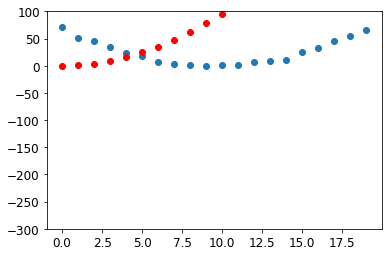

In [1056]:
# how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)

3. Calculate the loss

In [1057]:
loss = mse(preds, speed)
loss

tensor(139.0761, grad_fn=<SqrtBackward>)

4. Calculate the gradients

In [1058]:
loss.backward()

In [1059]:
params.grad * 1e-5 # 1e-5 learning rate

tensor([1.6478e-03, 1.0609e-04, 6.6289e-06])

In [1060]:
params

tensor([ 0.9215,  0.4636, -0.7267], requires_grad=True)

5. Step the weights

In [1061]:
# update the parameters based on the gradients we just calculated
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [1062]:
preds = f(time,params)
mse(preds, speed)

tensor(138.8034, grad_fn=<SqrtBackward>)

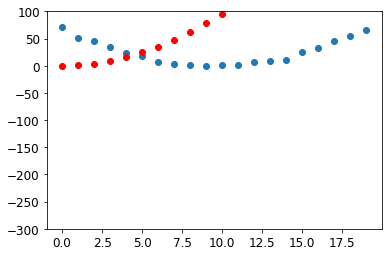

In [1063]:
show_preds(preds)

6. Repeat the process

In [1064]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds
for i in range(10): apply_step(params)

138.80340576171875
138.53077697753906
138.2582244873047
137.9856719970703
137.7131805419922
137.44070434570312
137.1682891845703
136.89590454101562
136.62355041503906
136.35125732421875


In [1065]:
params = orig_params.detach().requires_grad_()

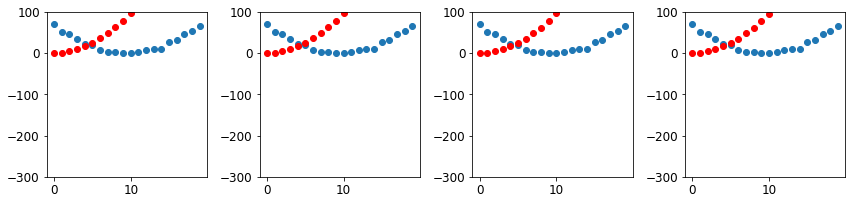

In [1066]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()


7. stop
